## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [12]:
import os
import keras
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [13]:
train, test = keras.datasets.cifar10.load_data()

In [14]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y

In [15]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [16]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [17]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
PATIENCE = [10, 25]

In [18]:

# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
from keras.callbacks import EarlyStopping

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for pt in itertools.product(PATIENCE):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with PATIENCE = %.6f" % (pt))

    earlystop = EarlyStopping(monitor="val_acc", 
                          patience=int(pt[0]), 
                          verbose=1
                          )
    
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[earlystop]
         )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "exp-patience-%s" % (str(pt))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with PATIENCE = 10.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128

Epoch 3/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.6157 - acc: 0.4349 - val_loss: 1.6997 - val_acc: 0.4130
Epoch 4/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.5397 - acc: 0.4602 - val_loss: 1.6490 - val_acc: 0.4248
Epoch 5/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.4825 - acc: 0.4803 - val_loss: 1.6035 - val_acc: 0.4395
Epoch 6/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.4377 - acc: 0.4974 - val_loss: 1.5742 - val_acc: 0.4494
Epoch 7/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.3960 - acc: 0.5113 - val_loss: 1.5601 - val_acc: 0.4520
Epoch 8/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.3620 - acc: 0.5230 - val_loss: 1.5310 - val_acc: 0.4608
Epoch 9/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.3291 - acc: 0.5374 - val_loss: 1.5211 - val_acc: 0.4685
Epoch 10/50
50000/50000 [================

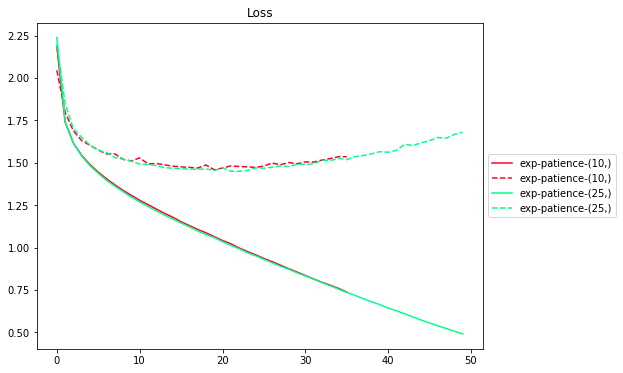

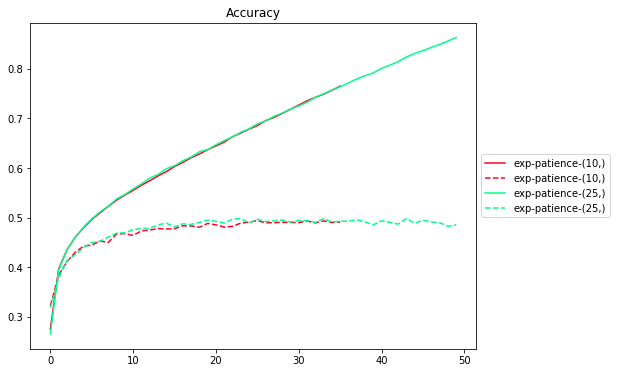

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()